In [17]:
import pandas as pd
import sqlite3
from bisect import bisect
import numpy as np

from matplotlib.pyplot import yscale, xscale, title, plot
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

In [4]:
def read_sql():
    df = __read_sql()
    df = __select_taipei_area(df)
    df = __clean_raw_dataframe(df)
    return df

# read raw data from sql
def __read_sql():
    con = sqlite3.connect('../data/InstagramPost.sqlite')
    con2 = sqlite3.connect('../data/InstagramPost2.sqlite')
    con3 = sqlite3.connect('../data/InstagramPost3.sqlite')
    SQL = pd.read_sql_query('select * from InstagramPost', con)
    SQL2 = pd.read_sql_query('select * from InstagramPost_table2', con)
    SQL3 = pd.read_sql_query('select * from InstagramPost_table3', con)
    SQL4 = pd.read_sql_query('select * from InstagramPost_table4', con)
    SQL5 = pd.read_sql_query('select * from InstagramPost_table2', con2)
    SQL6 = pd.read_sql_query('select * from InstagramPost', con3)

    # concat SQL tables
    SQL = pd.concat([SQL, SQL2, SQL3, SQL4, SQL5, SQL6]).drop_duplicates()
    del SQL2, SQL3, SQL4, SQL5, SQL6
    SQL['datetime'] = pd.to_datetime(SQL.date, unit='s')
    instagram2016 = SQL[SQL.datetime.dt.year == 2016]
    del SQL
    return instagram2016

# select taipei area
def __select_taipei_area(df):
#     # 基隆路附近
#     lat_min = 25.032840
#     lat_max = 25.051496
#     lng_min = 121.557441
#     lng_max = 121.580229
    
#     # 台北市
#     lat_min, lng_min = 24.975456, 121.461888
#     lat_max, lng_max = 25.100281, 121.611286

    # 信义松山
    lat_min, lat_max = 25.028791, 25.06338
    lng_min, lng_max = 121.54733, 121.59

    df['lat'] = df.lat.astype(float)
    df['lng'] = df.lng.astype(float)

    lat_bound = df.lat.between(lat_min, lat_max)
    lng_bound = df.lng.between(lng_min, lng_max)
    df = df[lat_bound & lng_bound]
    return df

# clean datafrome
def __clean_raw_dataframe(df):
    df = df[['location_id', 'location_name', 'lat', 'lng', 'caption', 'comments',
             'date', 'media_id', 'is_video', 'likes', 'owner_id', 'thumbnail_src',
             'display_src', 'datetime']].reset_index().drop(columns='index')
    return df

# Import Data

In [5]:
# 信义松山区
ig2016 = read_sql()

In [13]:
# reMap
def reSample(x, *xkey):
    x = bisect(xkey, x)
    x = xkey[x-1]
    return x

def get_xkey(column, resolution=30):
    '''
    resolution -> how many division you need to divide into
    '''
    xmin = ig2016[column].min()
    xmax = ig2016[column].max()
    xkey = np.linspace(xmin, xmax, resolution)
    return xkey

In [16]:
ig2016.head()

,location_id,location_name,lat,lng,caption,comments,date,media_id,is_video,likes,owner_id,thumbnail_src,display_src,datetime
0,539785069465598,駱馬休息站,25.060489,121.558019,-\n「駱馬」\n哺乳綱 偶蹄目 駱駝科 \n駱馬又名無峰駱駝，是群居的動物，非常耐旱，牠的...,15,1477227676,1367407320455448673,0,77,472063179,https://instagram.ftpe7-4.fna.fbcdn.net/t51.28...,https://instagram.ftpe7-4.fna.fbcdn.net/t51.28...,2016-10-23 13:01:16
1,1030274404,珍妮姐姐,25.033070,121.574303,4y9m31d\n🎃🎃🎃萬聖節不搗蛋要幹嘛.....來當小小波麗士啦！🚔🚔🚔一個好老成的交警...,0,1477722698,1371559858339338657,0,10,471686179,https://instagram.ftpe7-4.fna.fbcdn.net/t51.28...,https://instagram.ftpe7-4.fna.fbcdn.net/t51.28...,2016-10-29 06:31:38
2,512246272215639,明城鎖印行,25.054319,121.579559,原來嘟嘟嘴,0,1463601509,1253102745434590928,1,9,3103213202,https://instagram.ftpe7-4.fna.fbcdn.net/t51.28...,https://instagram.ftpe7-4.fna.fbcdn.net/t51.28...,2016-05-18 19:58:29
3,1030059774,上順五金,25.045666,121.572621,殺氣⋯,0,1457411803,1201179727676509838,0,5,1656340962,https://instagram.ftpe7-4.fna.fbcdn.net/t51.28...,https://instagram.ftpe7-4.fna.fbcdn.net/t51.28...,2016-03-08 04:36:43
4,1019607899,三楊汽車,25.054525,121.569865,💞,0,1477558262,1370180471644660324,1,57,667536889,https://instagram.ftpe7-4.fna.fbcdn.net/t51.28...,https://instagram.ftpe7-4.fna.fbcdn.net/t51.28...,2016-10-27 08:51:02


# 2. Draw heatmap

In [20]:
# get grid
latKey = get_xkey('lat')
lngKey = get_xkey('lng')

# resample the coordinate
ig2016['Y'] = ig2016['lat'].apply(lambda x: reSample(x, *latKey))
ig2016['X'] = ig2016['lng'].apply(lambda x: reSample(x, *lngKey))

# take out the grid
ig_count = ig2016[['X', 'Y']]
ig_count.head()

,X,Y
0,121.557620,25.059795
1,121.573770,25.032394
2,121.578174,25.053838
3,121.572302,25.045499
4,121.569365,25.053838


In [24]:
xygroup = ig_count.groupby(['X', 'Y'])
gridCounting = xygroup.size().unstack(fill_value=0).sort_index(ascending=False)
gridCounting.head()

Y,25.02882,25.030011349261724,25.031202698523447,25.03239404778517,25.033585397046895,25.03477674630862,25.035968095570343,25.037159444832067,25.038350794093795,25.03954214335552,...,25.05264698523448,25.053838334496206,25.055029683757933,25.056221033019657,25.05741238228138,25.058603731543105,25.05979508080483,25.060986430066553,25.062177779328277,25.06336912859
X,,,,,,,,,,,,,,,,,,,,,
121.589920,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
121.588452,0,0,0,0,0,0,0,0,0,13,...,104,0,0,11,0,83,8,0,0,0
121.586984,0,0,0,0,0,0,270,0,180,0,...,7,0,0,0,89,12,0,10,10,0
121.585515,0,0,1,0,0,574,0,54,7,3,...,88,0,337,173,10,2,0,96,8,0
121.584047,0,0,90,3,55,0,0,230,14,4,...,0,0,0,19,61,4,0,2,103,0


In [37]:
grid = pd.DataFrame(xygroup.size().reset_index()).rename(columns={0: 'value'})

grid.to_csv('instagramHeatmap.csv', encoding='utf8')

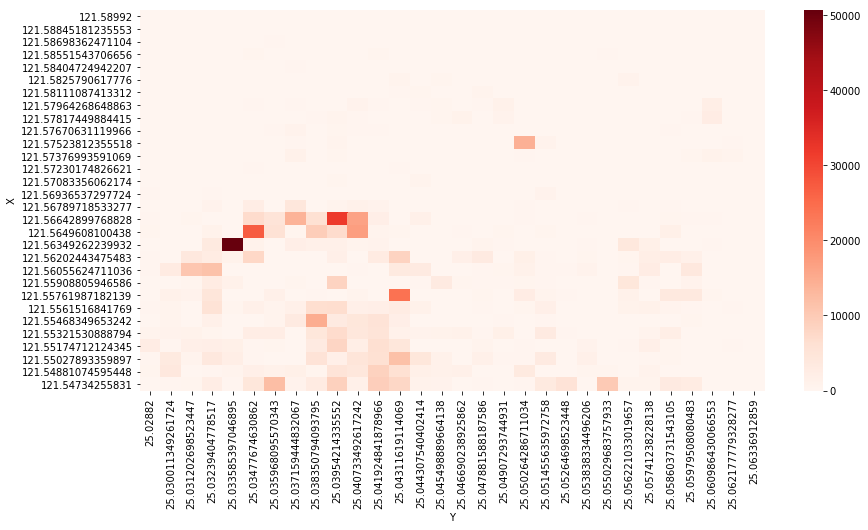

In [25]:
plt.rcParams['figure.figsize']=(14,7)
sns.heatmap(gridCounting, cmap='Reds')